# File and libraries

In [24]:
import pandas as pd
import numpy as np


filepath=r'google_merch_store_raw_merge.csv'

file_tag = "ga4_merch_store"


## DSLabs

In [25]:
%run "dslabs_functions.py"

# Load

In [26]:
test_data=True
# test_data=False

if test_data==True:
    # Specify the chunk size (e.g., load 1000 lines at a time)
    chunk_size = 50000

    # Initialize an empty list to store the chunks
    chunks = []

    # Load the first chunk (or any number of chunks you want)
    for chunk in pd.read_csv(filepath, chunksize=chunk_size, parse_dates=["event_date"],date_format="%Y-%m-%d"):
        chunks.append(chunk)
        # Break after the first chunk to load only a sample
        break

    # Concatenate the chunks into a single DataFrame (optional)
    data = pd.concat(chunks)
    

else:
    data=pd.read_csv(filepath)
 
    data=data.sample(frac=0.05, replace=False)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 48 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   event_date                       50000 non-null  datetime64[ns]
 1   session_id                       50000 non-null  int64         
 2   user_pseudo_id                   50000 non-null  float64       
 3   event_name                       50000 non-null  object        
 4   event_timestamp                  50000 non-null  int64         
 5   page_location                    50000 non-null  object        
 6   page_title                       49823 non-null  object        
 7   device_category                  50000 non-null  object        
 8   device_mobile_brand_name         50000 non-null  object        
 9   device_mobile_model_name         50000 non-null  object        
 10  device_mobile_marketing_name     50000 non-null  object   

# Remove Columns

### low value or high null count columns

In [27]:
data=data.drop(['debug_mode','device_is_limited_ad_tracking','device_mobile_marketing_name','geo_metro','traffic_source_name','page_referrer','entrances'],axis=1)

### ecommerce specific columns

In [28]:
data=data.drop([
 'ecommerce_total_item_quantity', 
 'ecommerce_purchase_revenue',            
 'ecommerce_shipping_value',              
 'ecommerce_tax_value',                   
 'ecommerce_unique_items',               
 'ecommerce_transaction_id',              
 'item_id',                               
 'item_name',                             
 'item_brand',                            
 'item_variant',                          
 'item_category',                         
 'price',                                 
 'quantity',                              
 'item_revenue',                          
 'item_list_index',                       
 'promotion_name'],axis=1)

# Dimensionality

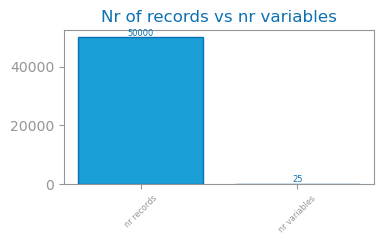

In [29]:
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import plot_bar_chart

figure(figsize=(4, 2))
values: dict[str, int] = {"nr records": data.shape[0], "nr variables": data.shape[1]}
plot_bar_chart(
    list(values.keys()), list(values.values()), title="Nr of records vs nr variables"
)
# savefig(f"{file_tag}_records_variables.png")
show()

### event_name insights
We want to classify a user by its interactions with the website so we want to exclude some actions that may also be biased by incorrect ga4 tracking namely:
- session_start
- first_visit
- click (low event count)
- view_item_list (may not be triggered by user interaction)

In [30]:
# List of values to drop
events_to_drop = ['session_start', 'first_visit','click','view_item_list']

# drop events from list
data = data[~data['event_name'].isin(events_to_drop)]


data['event_name'].value_counts()

event_name
view_item              15791
page_view              10380
user_engagement         7970
scroll                  3645
add_to_cart             3291
select_item             1617
view_promotion          1356
begin_checkout           583
view_search_results      192
add_shipping_info        145
purchase                 123
add_payment_info          99
select_promotion          65
Name: count, dtype: int64

# replace (not set) and Other with null

we will handle these later but these are actually null values

In [31]:
data.replace('(not set)', np.nan, inplace=True)

# data.replace('<Other>', np.nan, inplace=True)


In [32]:
data['engagement_time_msec'] = data['engagement_time_msec'].fillna(0)


## Missing values

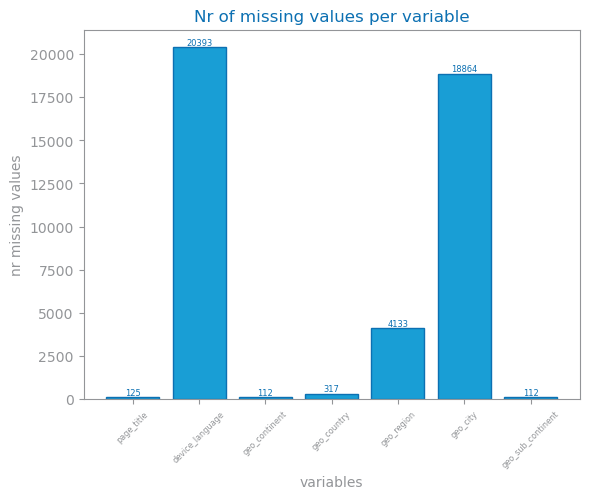

In [33]:
mv: dict[str, int] = {}
for var in data.columns:
    nr: int = data[var].isna().sum()
    if nr > 0:
        mv[var] = nr

figure()
plot_bar_chart(
    list(mv.keys()),
    list(mv.values()),
    title="Nr of missing values per variable",
    xlabel="variables",
    ylabel="nr missing values",
)
# savefig(f"{file_tag}_mv.png")
show()

## Variables Type

In [11]:
data.dtypes


event_date                         datetime64[ns]
session_id                                  int64
user_pseudo_id                            float64
event_name                                 object
event_timestamp                             int64
page_location                              object
page_title                                 object
device_category                            object
device_mobile_brand_name                   object
device_mobile_model_name                   object
device_operating_system                    object
device_operating_system_version            object
device_language                            object
device_web_info_browser                    object
device_web_info_browser_version            object
geo_continent                              object
geo_country                                object
geo_region                                 object
geo_city                                   object
geo_sub_continent                          object


In [10]:
from pandas import Series, to_numeric, to_datetime


def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": []}

    nr_values: Series = df.nunique(axis=0, dropna=True)
    for c in df.columns:
        if 2 == nr_values[c]:
            variable_types["binary"].append(c)
            df[c].astype("bool")
        else:
            try:
                to_numeric(df[c], errors="raise")
                variable_types["numeric"].append(c)
            except ValueError:
                try:
                    df[c] = to_datetime(df[c], errors="raise")
                    variable_types["date"].append(c)
                except ValueError:
                    variable_types["symbolic"].append(c)

    return variable_types


variable_types: dict[str, list] = get_variable_types(data)
print(variable_types)

{'numeric': ['event_date', 'session_id', 'user_pseudo_id', 'event_timestamp', 'ga_session_number', 'engagement_time_msec'], 'binary': ['session_engaged'], 'date': [], 'symbolic': ['event_name', 'page_location', 'page_title', 'device_category', 'device_mobile_brand_name', 'device_mobile_model_name', 'device_operating_system', 'device_operating_system_version', 'device_language', 'device_web_info_browser', 'device_web_info_browser_version', 'geo_continent', 'geo_country', 'geo_region', 'geo_city', 'geo_sub_continent', 'traffic_source_medium', 'traffic_source_source']}


## box plot variables

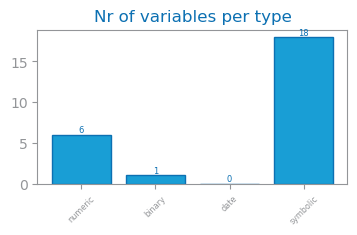

In [12]:
counts: dict[str, int] = {}
for tp in variable_types.keys():
    counts[tp] = len(variable_types[tp])

figure(figsize=(4, 2))
plot_bar_chart(
    list(counts.keys()), list(counts.values()), title="Nr of variables per type"
)
# savefig(f"{file_tag}_variable_types.png")
show()

# Data Distribution

## describe

In [9]:
summary5: DataFrame = data.describe(include="all")
summary5

,event_date,session_id,user_pseudo_id,event_name,event_timestamp,page_location,page_title,device_category,device_mobile_brand_name,device_mobile_model_name,...,item_id,item_name,item_brand,item_variant,item_category,price,quantity,item_revenue,item_list_index,promotion_name
count,50000,5.000000e+04,5.000000e+04,50000,5.000000e+04,50000,49823,50000,50000,50000,...,21244,21244,21235,21097,21151,20239.000000,901.000000,21244.000000,20594.000000,21141
unique,NaN,NaN,NaN,17,NaN,609,411,3,8,10,...,739,406,6,33,67,NaN,NaN,NaN,NaN,6
top,NaN,NaN,NaN,view_item,NaN,https://shop.googlemerchandisestore.com/,Home,desktop,Apple,Chrome,...,(not set),(not set),(not set),(not set),Home/Apparel/Men's / Unisex/,NaN,NaN,NaN,NaN,(not set)
freq,NaN,NaN,NaN,15791,NaN,5094,8713,28892,21209,13879,...,918,1005,19502,20363,3409,NaN,NaN,NaN,NaN,19870
mean,2020-12-16 14:20:36.096000256,4.978973e+09,2.478379e+08,NaN,1.608172e+15,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,26.461189,1.621532,0.149595,6.946392,NaN
min,2020-11-01 00:00:00,6.412000e+03,1.000300e+06,NaN,1.604189e+15,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,0.000000,1.000000,NaN
25%,2020-11-23 00:00:00,2.508468e+09,5.706021e+06,NaN,1.606148e+15,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,13.000000,1.000000,0.000000,4.000000,NaN
50%,2020-12-15 00:00:00,4.968109e+09,2.033435e+07,NaN,1.608064e+15,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,22.000000,1.000000,0.000000,7.000000,NaN
75%,2021-01-10 00:00:00,7.461751e+09,5.997908e+07,NaN,1.610239e+15,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,30.000000,1.000000,0.000000,10.000000,NaN
max,2021-01-31 00:00:00,9.999205e+09,9.986757e+09,NaN,1.612137e+15,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,313.000000,204.000000,120.000000,24.000000,NaN


## numeric Variables

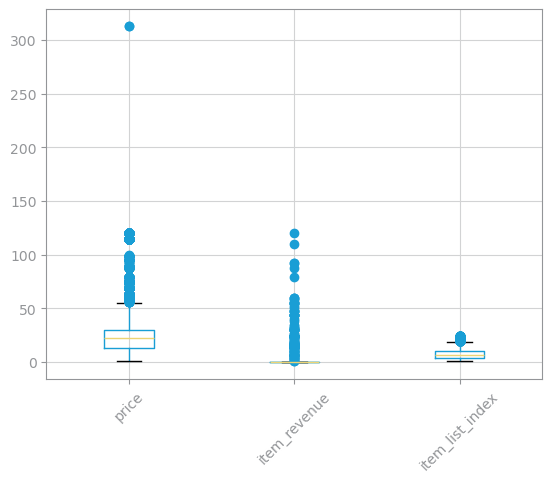

In [10]:
from matplotlib.pyplot import savefig, show


# variables_types: dict[str, list] = get_variable_types(data)
# numeric: list[str] = variables_types["numeric"]

# price is the only actual numeric variable as others are identifiers so might as well and filter for it
numeric: list[str] = ["price","item_revenue","item_list_index"]

if [] != numeric:
    data[numeric].boxplot(rot=45)
   # savefig(f"{file_tag}_global_boxplot.png")
    show()
else:
    print("There are no numeric variables.")

In [11]:
# from numpy import ndarray
# from matplotlib.figure import Figure
# from matplotlib.pyplot import savefig, show, subplots
# from dslabs_functions import define_grid, HEIGHT

# if [] != numeric:
#     rows: int
#     cols: int
#     rows, cols = define_grid(len(numeric))
#     fig: Figure
#     axs: ndarray
#     fig, axs = subplots(
#         rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
#     )
#     i, j = 0, 0
#     for n in range(len(numeric)):
#         axs[i, j].set_title("Boxplot for %s" % numeric[n])
#         axs[i, j].boxplot(data[numeric[n]].dropna().values)
#         i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
#     savefig(f"images/{file_tag}_single_boxplots.png")
#     show()
# else:
#     print("There are no numeric variables.")

# Balancing and class distribution

## first evaluation

ga_session_number
1      32407
2       6110
3       3481
4       2347
5       1466
6       1048
7        769
8        554
9        392
10       320
11       213
12       199
13       125
14        90
19        54
15        52
16        47
17        44
22        31
21        30
18        22
24        22
20        21
25        19
26        12
23        11
34         9
29         8
33         7
36         7
30         7
32         6
28         6
37         6
35         6
46         6
39         6
143        5
31         5
141        4
27         4
48         3
65         3
153        2
40         2
47         2
66         2
83         1
117        1
44         1
63         1
67         1
42         1
49         1
62         1
Name: count, dtype: int64


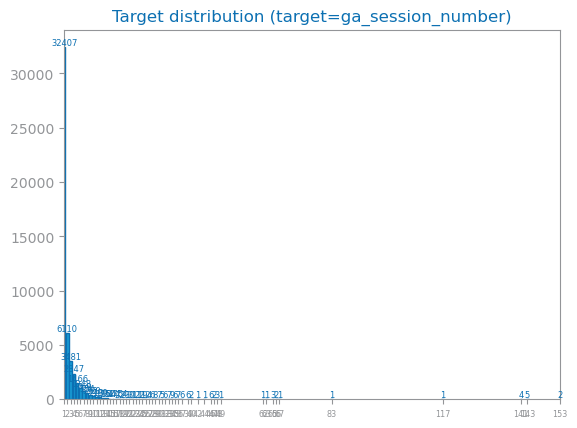

In [12]:
import matplotlib.pyplot as plt
    
from matplotlib.collections import PathCollection
from matplotlib.colorbar import Colorbar
from matplotlib.container import BarContainer
from matplotlib.figure import Figure
from matplotlib.font_manager import FontProperties
from matplotlib.axes import Axes
from matplotlib.pyplot import gca, gcf, savefig, subplots, text
from matplotlib.dates import AutoDateLocator, AutoDateFormatter

target = "ga_session_number"

values: Series = data[target].value_counts()
print(values)

Figure(figsize=(4, 2))
plot_bar_chart(
    values.index.to_list(),
    values.to_list(),
    title=f"Target distribution (target={target})",
)
#savefig(f"images/{file_tag}_class_distribution.png")
show()

## target column creation and distribution

we want to classify if that hit is from a returning or new user so we need to group the ga_session_number by 1 or more than 1 session. in this case, new user (ga_session_number = 1) will be 0 and returning user will be more than 1 (ga_session_number > 1)

In [22]:
data['returning_user'] = data['ga_session_number'].apply(lambda x: 0 if x == 1 else 1)

# data['returning_user'] = data['ga_session_number'].apply(lambda x: 0 if x < 8 else 1)



returning_user
0    32407
1    17593
Name: count, dtype: int64


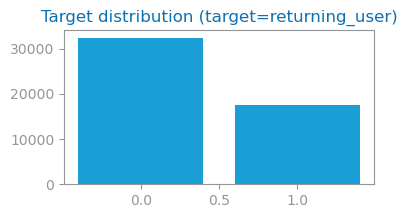

In [23]:
import matplotlib.pyplot as plt

target = "returning_user"

values = data[target].value_counts()
print(values)

# Criar a figura com o tamanho definido
plt.figure(figsize=(4, 2))

# Criar gráfico de barras
plt.bar(values.index.to_list(), values.to_list())

# Título
plt.title(f"Target distribution (target={target})")

# Guardar a figura
# plt.savefig(f"images/{file_tag}_class_distribution.png")

# Mostrar a figura
plt.show()

# Symbolic Variables

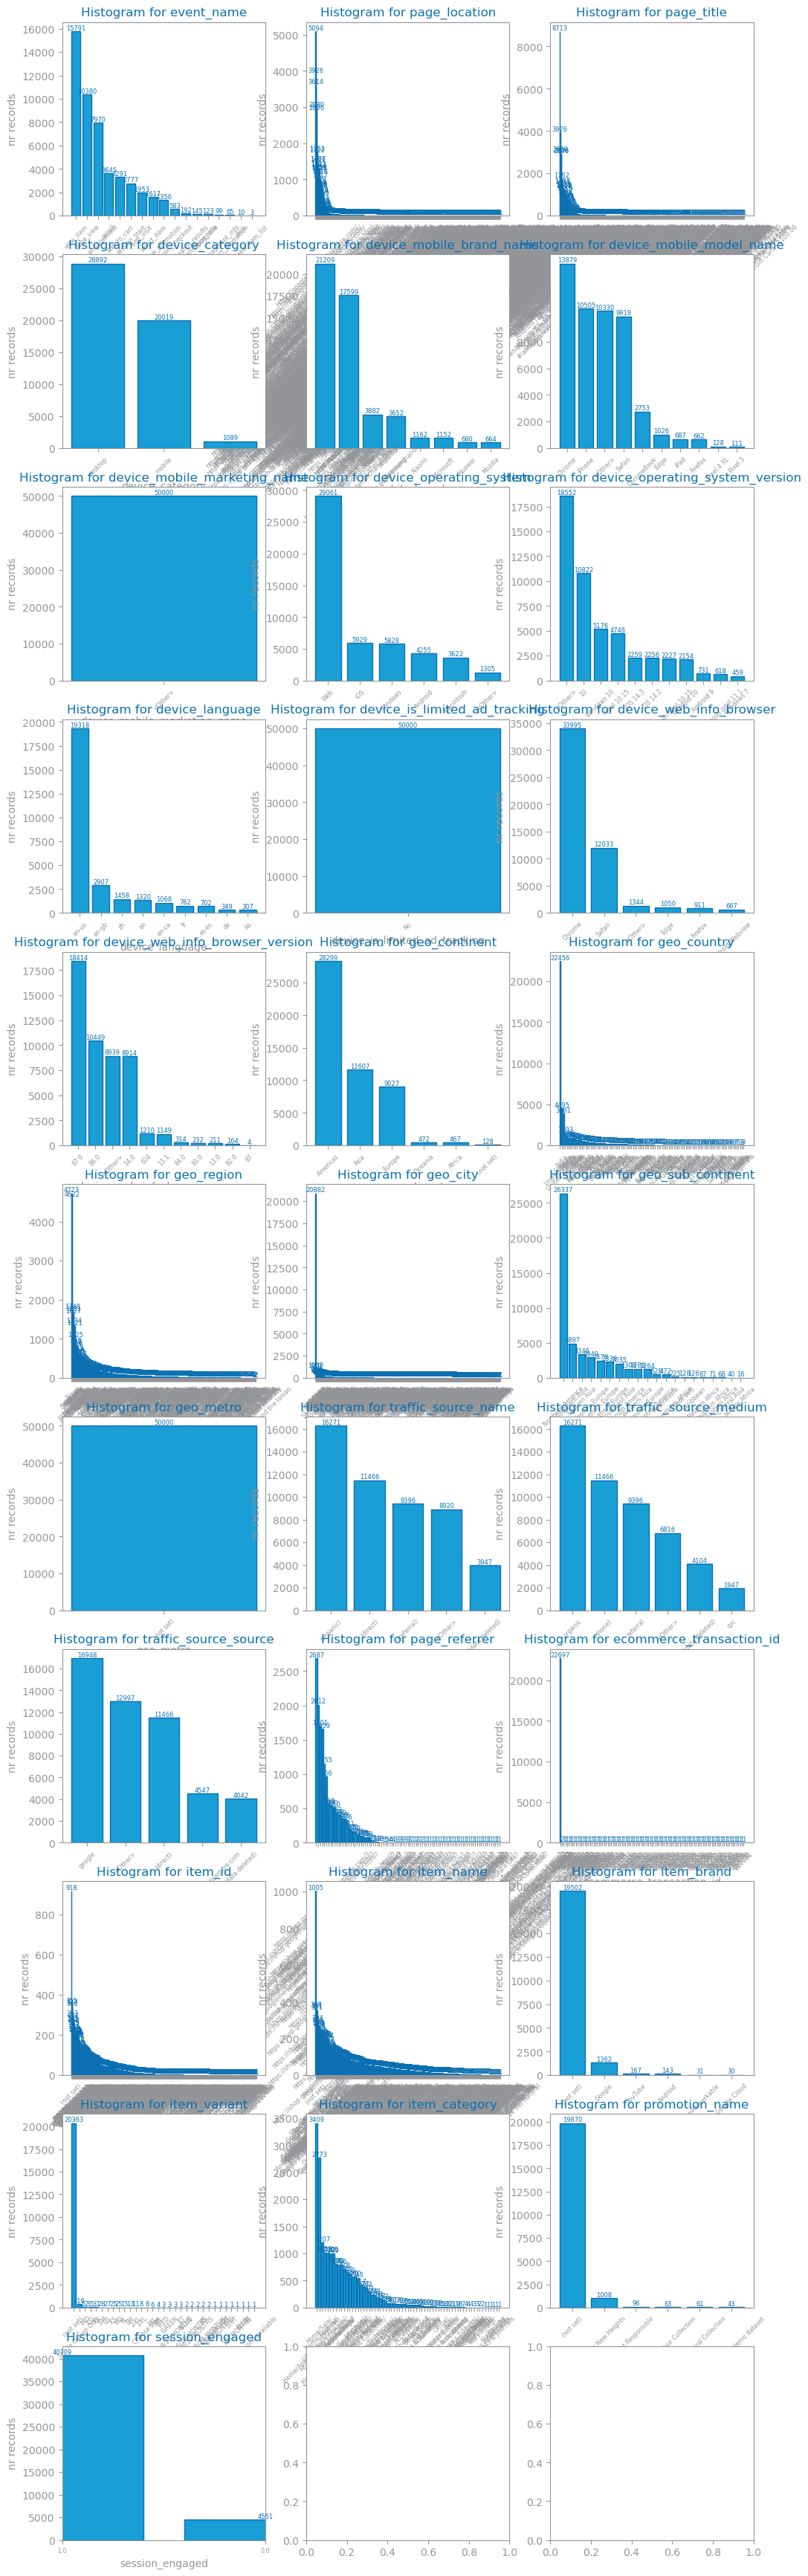

In [15]:
from dslabs_functions import plot_bar_chart

symbolic: list[str] = variable_types["symbolic"] + variable_types["binary"]
if [] != symbolic:
    rows, cols = define_grid(len(symbolic))
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i, j = 0, 0
    for n in range(len(symbolic)):
        counts: Series = data[symbolic[n]].value_counts()
        plot_bar_chart(
            counts.index.to_list(),
            counts.to_list(),
            ax=axs[i, j],
            title="Histogram for %s" % symbolic[n],
            xlabel=symbolic[n],
            ylabel="nr records",
            percentage=False,
        )
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    # savefig(f"{file_tag}_histograms_symbolic.png")
    show()
else:
    print("There are no symbolic variables.")

# Symbolic distribution per target variable counts

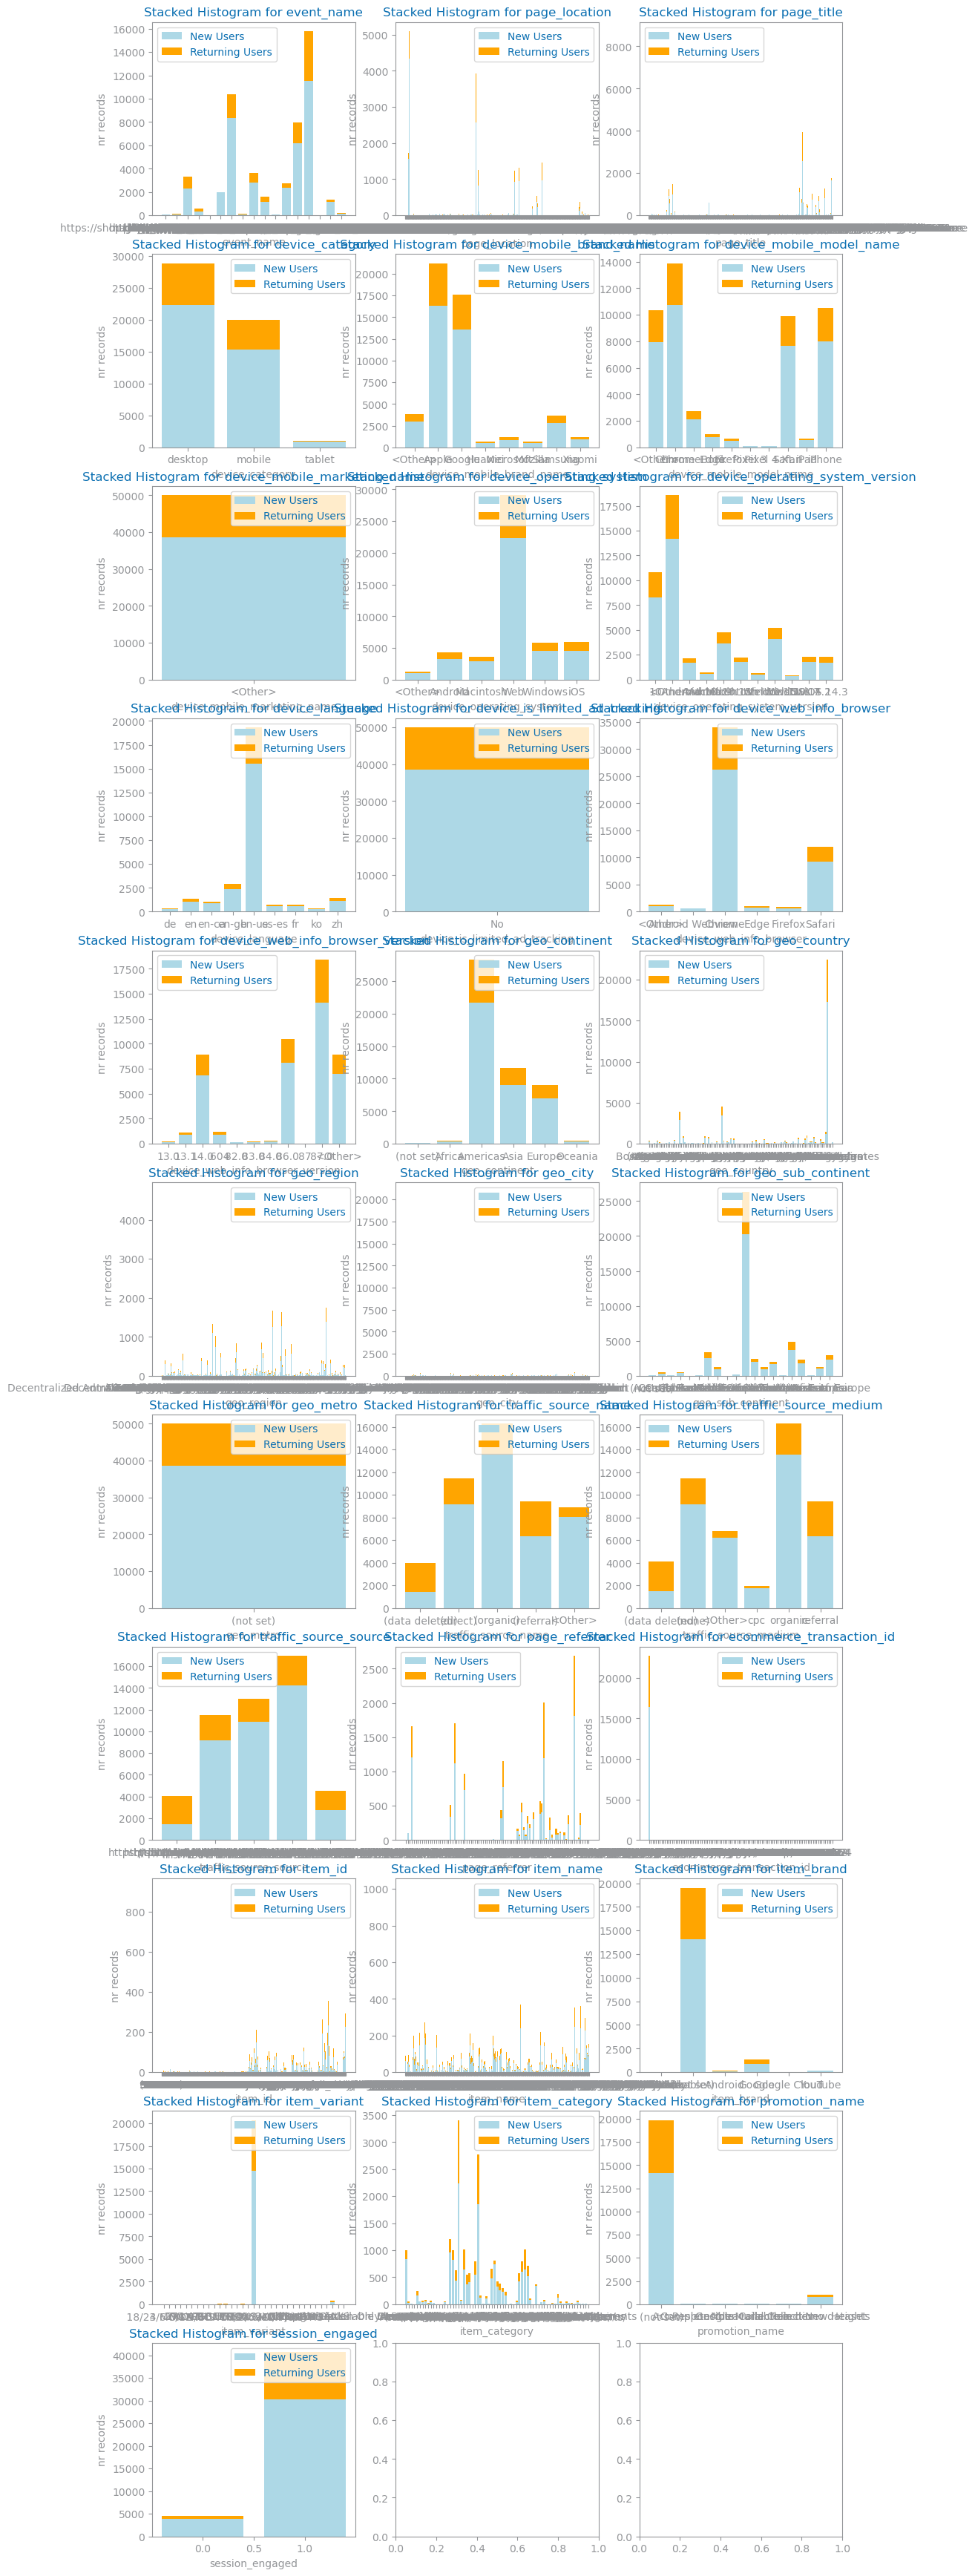

In [16]:
if [] != symbolic:
    rows, cols = define_grid(len(symbolic))
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i, j = 0, 0
    for n in range(len(symbolic)):
        # Group by the symbolic variable and 'returning_user', and get counts
        grouped_counts: pd.DataFrame = data.groupby([symbolic[n], 'returning_user']).size().unstack(fill_value=0)
        
        # Get the index (categories) and values (counts of new and returning users)
        categories = grouped_counts.index.to_list()
        new_users = grouped_counts[0].to_list()  # New users (ga_session_number = 1)
        returning_users = grouped_counts[1].to_list()  # Returning users (ga_session_number > 1)

        # Plot stacked bar chart
        axs[i, j].bar(categories, new_users, label="New Users", color="lightblue")
        axs[i, j].bar(categories, returning_users, bottom=new_users, label="Returning Users", color="orange")

        # Add chart details
        axs[i, j].set_title(f"Stacked Histogram for {symbolic[n]}")
        axs[i, j].set_xlabel(symbolic[n])
        axs[i, j].set_ylabel("nr records")
        
        # Add legend
        axs[i, j].legend()

        # Move to the next subplot
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)

    # Adjust layout
    fig.tight_layout()

### Filtered to top 10 value counts dimensions' per variable

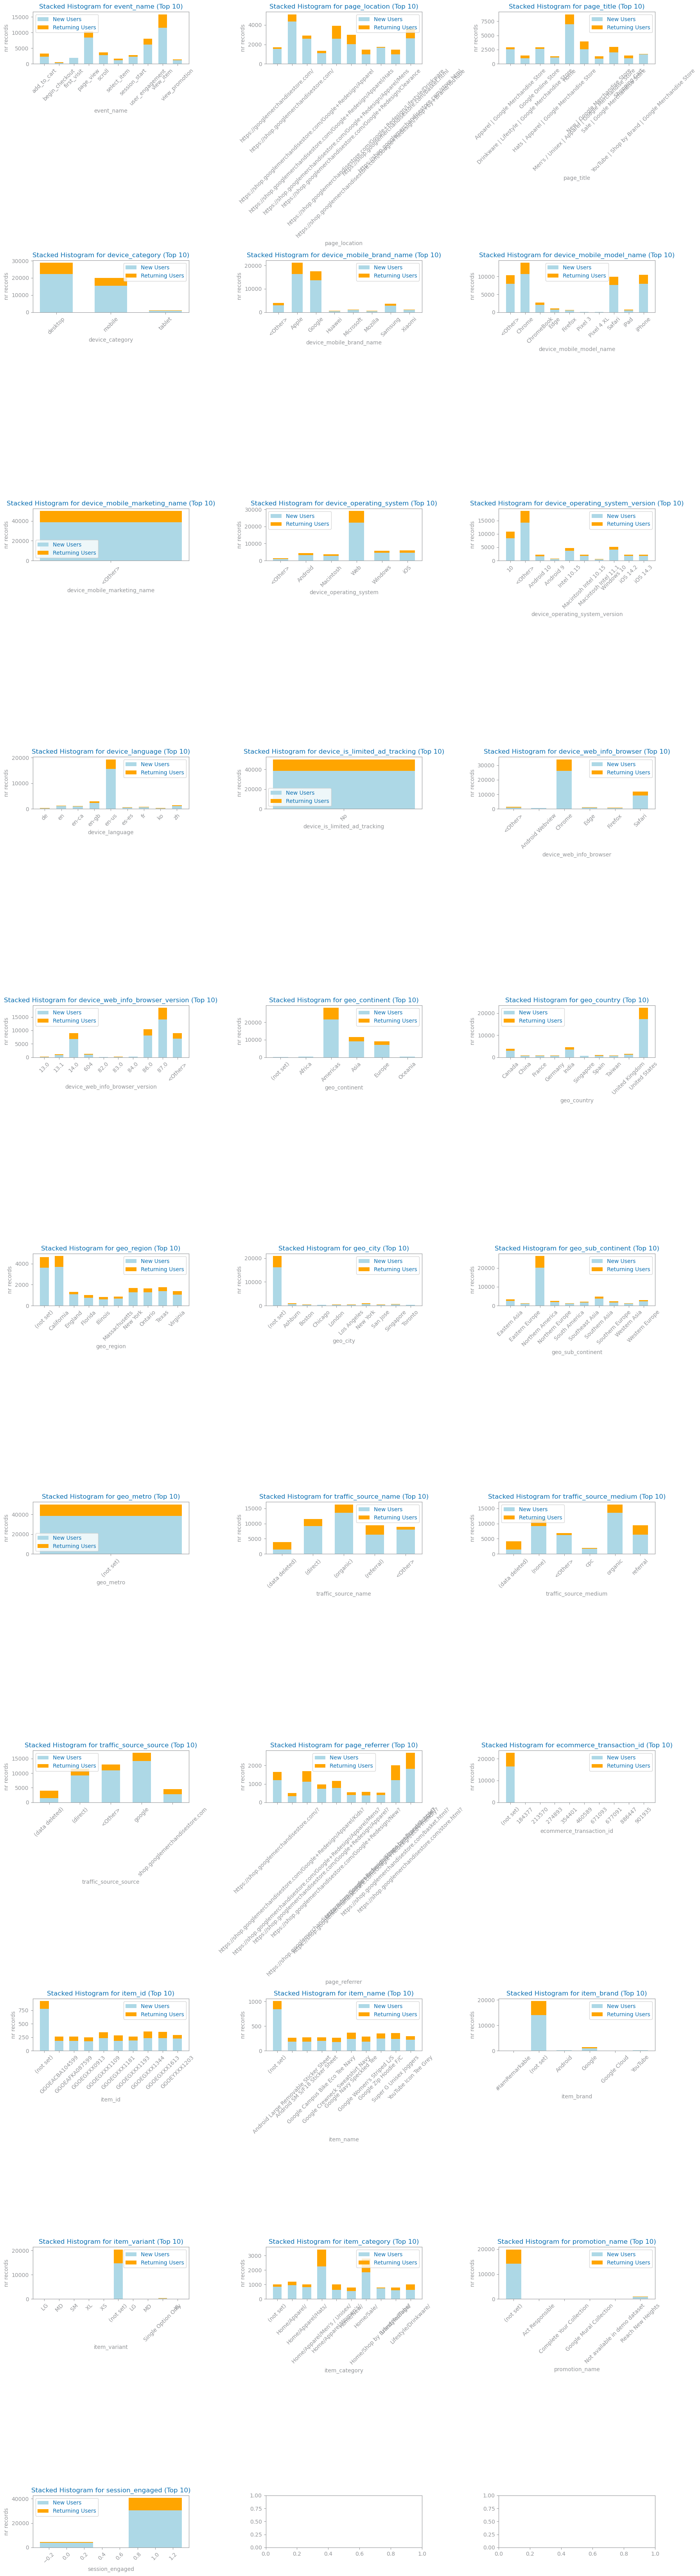

In [17]:

# Assuming you have already created a 'returning_user' column in your data

symbolic: list[str] = variable_types["symbolic"] + variable_types["binary"]

# Check if there are symbolic variables
if [] != symbolic:
    rows, cols = define_grid(len(symbolic))
    
    # Increase the figure size to improve spacing (adjust the scale as needed)
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT * 1.5, rows * HEIGHT * 1.5), squeeze=False
    )
    
    i, j = 0, 0
    for n in range(len(symbolic)):
        # Get value counts for the symbolic variable and limit to top 10 categories
        top_10_categories = data[symbolic[n]].value_counts().nlargest(10).index

        # Filter the data to include only the top 10 categories for the symbolic variable
        filtered_data = data[data[symbolic[n]].isin(top_10_categories)]

        # Group by the symbolic variable and 'returning_user', and get counts
        grouped_counts: pd.DataFrame = filtered_data.groupby([symbolic[n], 'returning_user']).size().unstack(fill_value=0)

        # Get the index (top 10 categories) and values (counts of new and returning users)
        categories = grouped_counts.index.to_list()
        new_users = grouped_counts[0].to_list()  # New users (ga_session_number = 1)
        returning_users = grouped_counts[1].to_list()  # Returning users (ga_session_number > 1)

        # Plot stacked bar chart with adjusted bar width
        bar_width = 0.6  # Adjust bar width
        axs[i, j].bar(categories, new_users, width=bar_width, label="New Users", color="lightblue")
        axs[i, j].bar(categories, returning_users, bottom=new_users, width=bar_width, label="Returning Users", color="orange")

        # Add chart details
        axs[i, j].set_title(f"Stacked Histogram for {symbolic[n]} (Top 10)")
        axs[i, j].set_xlabel(symbolic[n])
        axs[i, j].set_ylabel("nr records")
        
        # Rotate x-axis labels for better readability
        axs[i, j].tick_params(axis='x', rotation=45)

        # Add legend
        axs[i, j].legend()

        # Move to the next subplot
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)

    # Adjust layout for better fitting
    fig.tight_layout()

    # Show the plot
    show()

else:
    print("There are no symbolic variables.")



# Insights

1. Drop Columns
- geo metro - all "not set"
- geo city - very high share of null values
- id ad limited - all "No"
- device mobile marketing name - all "not set"
- device is limited ad tracking - all "no"
- traffic_source_name - duplicate from traffic source medium
- page_referrer
- Does it make sense to keep "promotion name" since it has a high share of null values and its only related to a specific event? maybe persist the last value for the session

2. Device encoding
- Browser version -> Find what is the release date to understand if its a recent or old version compared to session date
- try to make hierarchy between android/ios on mobile and mac/windows as well as browsers per OS

3. region encoding
- try to relate continent and region on hierarchy of values

4. ecommerce events
- remove string values from item_ids
- make hierarchy between clothing, categories and brands

5. other event names
- make hierarchy between ecommerce, non ecommerce/journey events

6. event_date
- add date granularity (year, quarter, month, day, hour, hour&minute, weekday/weekend)
